#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy import interpolate

In [2]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [5]:
node_N = 50

In [6]:
mi = [mp for i in range(node_N)] 

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 84.6 # [m]
B= 12
H=13
Xg = L/2 # [m]
mn =   27_162_500 #123000000 # mass of the vessel, [kg]  
# kp, kd=1.95e4,1.5e4

In [8]:
lx,ly,lz=L/2,B/2,H/2

In [9]:
vessel_mass=mn/L # mass over length of the vessel

In [10]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
 
Irho=np.diag(diag_Irho)

In [11]:
Irho

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [12]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [13]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [14]:
vessel_inertia

60751987031.24999

In [15]:
# Irho+=vessel_inertia

In [16]:
Irho

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [17]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [18]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [19]:
E = 210e9

In [20]:
E*Ar

16991625880.187403

In [21]:
diag_DT = 1.5*np.array([1, 1, 1]) 

In [22]:
DT=np.diag(diag_DT) # (35) in [2]

In [23]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [24]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [25]:
CT=np.diag(diag_CT)

In [26]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [27]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cφ,Cθ),Cψ) )

In [28]:
Re_t_([1,2,3])

array([[ 0.41198225,  0.05872664,  0.90929743],
       [-0.68124272, -0.64287284,  0.35017549],
       [ 0.60512725, -0.76371834, -0.2248451 ]])

In [29]:
rng = np.random.default_rng()

In [30]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [31]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [32]:
Re_t_(np.array([φ[0], θ[0], ψ[0]]))

array([[ 0.32903037, -0.33425957,  0.8831815 ],
       [ 0.68089358,  0.73200917,  0.02337731],
       [-0.65431105,  0.59366077,  0.46844844]])

In [33]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.008078


In [34]:
Ret.shape

(50, 3, 3)

In [35]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [36]:
def C1(dx,dy,dz, Ret): # here
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.linalg.solve(Ret,B.T.astype(np.float32))) 
    return ans.T

In [37]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000507


In [38]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [39]:
fD(dx,dy,dz,DT,Ret).T

array([[-7.62539217e+02, -1.35334619e+04,  7.78540951e+03],
       [-2.74365648e+03,  9.64806652e+03, -3.59486891e+03],
       [-2.18900294e+03,  6.67344692e+03, -4.33219751e+03],
       [-8.47264869e+03,  8.76973985e+03, -2.02445608e+04],
       [ 2.18914063e+01,  5.58549786e+03, -4.70373964e+04],
       [-1.13105437e+03,  7.62577529e+02,  1.62928039e+02],
       [ 1.52540607e+04, -1.96004796e+03, -1.08869487e+03],
       [-4.85356101e+03, -3.32835203e+02, -1.41780562e+04],
       [ 5.96645780e+03, -1.68700352e+03, -1.14444628e+03],
       [ 4.41614165e+02,  6.11170545e+03, -3.63016803e+02],
       [-1.17617869e+03,  8.93330483e+03, -1.42199292e+03],
       [-4.46211215e+00,  5.93698479e+03, -4.34298752e+03],
       [-2.80130643e+00, -1.19849417e+03,  1.44090622e+04],
       [-5.57045896e+03,  4.59820380e+03,  5.25567476e+03],
       [-6.44749132e+02,  1.74921891e+03, -1.15269285e+02],
       [-2.45020242e+03, -2.38418013e+04,  1.56519109e+04],
       [ 3.61648767e+02,  2.29230559e+03

In [40]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000321


In [41]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [42]:
I=np.identity(3)

In [43]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.002553


In [44]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [45]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [46]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [47]:
DR=np.diag(diag_DR) 

In [48]:
Ar

0.08091250419136858

In [49]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [50]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [51]:
x,y,z=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [52]:
def Re_b(Ret):
    return Ret

In [53]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000133


In [54]:
def phi(x, y, z, Ret,dummy,dummy1): # here
    B=np.vstack([x,y,z])
    return np.linalg.solve(Ret.astype(np.float32),B.T.astype(np.float32))
#     return np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float32))

In [55]:
phi(x,y,z,Ret,None,None)

array([[ 8.22942734e-01,  2.05536678e-01, -5.89306951e-01],
       [ 4.02045816e-01, -1.22234333e+00,  1.19765794e+00],
       [-1.28869712e+00,  2.28099391e-01,  1.29767621e+00],
       [ 1.92977950e-01,  1.29034567e+00, -1.87017351e-01],
       [ 4.21775043e-01, -1.92669317e-01, -6.98611975e-01],
       [-2.74990941e-03, -1.13185637e-01,  2.93562412e-01],
       [-2.12042212e+00,  3.00814867e-01,  2.11172312e-01],
       [ 6.25183046e-01,  6.77077949e-01, -8.46415818e-01],
       [-3.91391627e-02, -9.97253418e-01, -1.02818704e+00],
       [-4.54581916e-01,  7.96798766e-01, -9.93130326e-01],
       [ 3.14917654e-01, -1.21990824e-02,  1.23128939e+00],
       [-1.50979221e+00,  7.30416596e-01, -4.78312701e-01],
       [-1.38905251e+00,  1.80364633e+00,  6.81379735e-01],
       [ 1.72452003e-01,  5.19670367e-01, -1.12009287e+00],
       [ 1.49871230e+00, -8.43496799e-01, -1.69204950e-01],
       [-1.20934412e-01, -6.18162632e-01, -1.81565440e+00],
       [-4.19482112e-01, -5.39184511e-01

In [56]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None,None)
print(datetime.now() - startTime1)

0:00:00.000375


In [57]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [58]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [59]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.002255


In [60]:
def ωe(φ,θ,ψ, dummy,dummy1,dummy2): # here # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float32))

In [61]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None,None)
print(datetime.now() - startTime1)

0:00:00.003207


In [62]:
ωe(φ,θ,ψ,None,None,None)

array([[ 0.67635398,  1.12214111,  0.41564908],
       [ 0.60559675, -1.14115353,  0.86353386],
       [ 0.38973739, -0.81574386,  0.89961789],
       [ 0.04156215,  1.30347534, -1.85011113],
       [-0.18595513,  0.67766552, -0.01260528],
       [-0.00977909,  0.04100214,  0.18007772],
       [-1.21430712, -0.81064104, -0.34368469],
       [-1.18005913,  0.02211853,  0.24233868],
       [ 0.7712539 , -0.33606475, -0.09436017],
       [ 0.34067643,  0.21514782, -1.21554508],
       [-0.26508481, -0.88159132, -0.5538473 ],
       [ 0.05196742, -1.57855071,  0.95723199],
       [-1.0844974 , -0.59684536, -0.7549806 ],
       [-0.54763699,  0.95168519,  1.20535194],
       [ 1.26452465,  0.48586654,  0.46462844],
       [-0.32247291, -0.7925774 , -0.84612194],
       [-0.14378584, -1.25733537, -0.55488884],
       [-0.49364522,  0.88925387,  0.8545905 ],
       [ 0.53451672, -0.5048826 ,  0.34756735],
       [-1.8487672 ,  1.03381028, -1.16883123],
       [-0.24491062,  0.45511858, -0.293

In [63]:
def d_s(f,a,b,c,Ret,omega, force, flag=0): # here
    
    fun = f(a,b,c,Ret,omega, force) 
    
    if flag==1:
        fun+=-np.dot(Ret,force)
    elif flag==2:
        fun+=-np.dot(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),Re_b(Ret)),force)
# #     print(fun)
#     if any(force):
# #         fun[-1]=-np.array(force)
#         fun[-1]=-np.dot(Ret[-1],force)
# #         fun+=-np.dot(Ret,force) # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# #     print(fun)

    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    K=np.apply_along_axis(S, 1, omega)
    
    
   
    return np.einsum('ijk,ik->ij',K, fun.astype(np.float32)).T

In [64]:
φ, θ, ψ = np.array([0.00001 for i in range(node_N)]),np.array([0.00001 for i in range(node_N)]),np.array([0.00001 for i in range(node_N)])

In [65]:
d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None), [1,20,3],flag=2)

array([[ 1.97225977e-05,  4.64241809e-05,  5.86771423e-05,
        -2.83230803e-04,  2.16559142e-04,  1.75464054e-04,
         1.95056080e-04,  2.35145181e-04, -9.08479071e-05,
        -3.78912751e-05,  2.54110850e-04,  1.18731834e-05,
         2.52793348e-04,  1.85199992e-04, -2.01930148e-04,
         1.42337286e-04,  2.80651474e-04,  1.82090793e-04,
         2.61725662e-06, -3.71599285e-06,  2.17618379e-04,
         1.25797198e-04,  1.71915775e-04,  2.16428113e-05,
         2.42652644e-04,  7.33503808e-05,  2.55169885e-04,
         7.31964450e-05,  2.93862257e-06,  2.68941567e-04,
        -1.77960867e-04, -7.98948863e-06, -5.12418938e-05,
         1.68735484e-04,  2.61426498e-04, -9.00228535e-06,
         1.08964555e-04,  9.48178048e-05,  2.26028851e-04,
        -3.41390906e-05,  4.80117181e-05,  4.58615998e-05,
        -1.53771394e-04, -1.35235256e-04, -9.72680735e-05,
         6.32274678e-05,  4.55124965e-05,  8.41975831e-05,
         1.76013765e-04,  1.65465676e-04],
       [ 1.77

In [66]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,0])
print(datetime.now() - startTime1)

0:00:00.028658


In [67]:
def ne(x,y,z,Ret,omega,force): # here
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega,force,flag=1).T
    return np.einsum('ijk,ik->ij', A.astype(np.float32),B
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float32), np.array([1,0,0]).reshape(3,1)).squeeze()
                    )

In [68]:
φ, θ, ψ = np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)])

In [69]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,0])

array([[-7.80140482e-07,  2.30611028e-06, -1.64635493e-07,
         1.21420067e-06, -2.87574301e-07,  4.11175167e-07,
         1.32586990e-06,  2.62907793e-07, -1.57032615e-06,
        -2.27209960e-06, -6.85276298e-08, -1.61757041e-06,
         1.85876353e-06,  2.46020488e-07, -1.46377867e-06,
         9.24780902e-07, -1.19218379e-07,  1.37110346e-06,
        -4.88480495e-07, -1.54925477e-06,  2.77332728e-07,
         2.18001076e-06,  9.34295016e-08, -1.05993743e-06,
        -3.22518732e-06,  5.65245218e-07, -1.62166567e-07,
         1.84345037e-06,  2.97087252e-07, -3.76728425e-07,
         8.52064634e-07,  1.09827516e-06, -1.81715861e-06,
         1.07185358e-06,  2.32463383e-06, -2.78880358e-06,
         2.00747716e-07, -2.04209463e-06, -8.20230019e-08,
        -1.72058565e-06,  2.29189053e-06, -2.95066061e-07,
        -7.14921682e-07,  6.36709052e-07,  1.87531480e-06,
         2.97341883e-06, -4.63875067e-08,  5.51851435e-08,
         6.34426971e-07, -1.07583096e-06],
       [-3.66

In [70]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [71]:
ne_(dx,dy,dz,DT,Ret)

array([[ 7.62539217e+02,  2.74365648e+03,  2.18900294e+03,
         8.47264869e+03, -2.18914063e+01,  1.13105437e+03,
        -1.52540607e+04,  4.85356101e+03, -5.96645780e+03,
        -4.41614165e+02,  1.17617869e+03,  4.46211215e+00,
         2.80130643e+00,  5.57045896e+03,  6.44749132e+02,
         2.45020242e+03, -3.61648767e+02,  7.70643852e+03,
         8.69488194e+03,  1.75629657e+03,  1.11872414e+02,
        -1.67734006e+02,  4.37054213e+01, -1.28945802e+04,
        -1.59583919e+04, -2.90470739e+03,  3.00600659e+04,
        -1.24697008e+04,  2.70064490e+03,  1.90893280e+04,
        -9.85547433e+02,  2.43420537e+03,  1.71284098e+03,
         4.70940517e+02,  1.64554717e+03, -4.68614360e+03,
         1.21080433e+04,  1.15615146e+04, -6.71872782e+03,
        -6.07897316e+03,  3.64544982e+01,  1.11101799e+04,
        -7.01757406e+02, -2.15323322e+03, -3.05395935e+03,
         2.21134866e+04, -4.92791025e+03, -1.02473238e+04,
        -1.05902281e+04,  4.69845420e+04],
       [ 1.35

In [72]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,1])
print(datetime.now() - startTime1)

0:00:00.003164


In [73]:
d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None), [0,0,1]).T

array([[ 5.08431890e+02, -1.79206048e+02, -3.29226860e+02],
       [-1.32524443e+02, -9.13204397e+00,  1.41656752e+02],
       [-1.57900466e+02,  1.79486587e+02, -2.15858053e+01],
       [ 2.00598476e+02, -4.60411390e-02, -2.00552836e+02],
       [ 1.52694951e+02, -7.95965703e+02,  6.43270446e+02],
       [ 2.12592779e+02, -9.90744527e+02,  7.78151323e+02],
       [-8.82787675e+01, -2.77862718e+02,  3.66141662e+02],
       [-4.62726196e+01, -7.58264006e+02,  8.04536718e+02],
       [-2.33676998e+02, -1.93142410e+02,  4.26819875e+02],
       [ 1.23250284e+02, -2.12765290e+02,  8.95147586e+01],
       [-1.77486278e+02, -9.44610905e+01,  2.71947724e+02],
       [-3.77890647e+02,  4.24327173e+00,  3.73648131e+02],
       [ 2.66708568e+01, -5.44303111e+02,  5.17632201e+02],
       [-4.70237654e-01, -4.67299388e+01,  4.72001773e+01],
       [-1.34833465e+01, -1.04213817e+02,  1.17697191e+02],
       [-6.07566223e+02,  1.08795122e+02,  4.98772316e+02],
       [ 2.76507603e+02,  2.84787874e+01

In [74]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[1,23,4])

array([[-3.56209408e+07, -3.64837507e+08,  1.43579765e+08],
       [-2.22566006e+08, -8.08981539e+07, -2.13442765e+08],
       [-1.87876342e+08, -2.09454488e+08, -3.67383421e+08],
       [-1.56686246e+05, -2.00705142e+08, -1.10551996e+05],
       [-4.41564328e+08,  2.01683663e+08,  3.54376437e+08],
       [-9.50435065e+08, -1.72296522e+08,  4.02650902e+07],
       [-3.51596043e+08,  1.45324556e+07, -7.37432318e+07],
       [-7.78003620e+08,  2.65075497e+07, -1.97631076e+07],
       [-2.43193352e+08,  1.83632639e+08, -5.00466524e+07],
       [-2.43633599e+07,  6.51503884e+07,  1.88418348e+08],
       [-3.65844475e+08, -9.39181824e+07, -2.71404471e+08],
       [-1.47475365e+07,  3.58912733e+08, -1.89914857e+07],
       [-5.49497350e+08, -3.18858834e+07, -5.21422893e+06],
       [-4.68491876e+07,  3.48009595e+05, -1.22179512e+05],
       [-6.92461684e+07,  4.84547183e+07,  3.49728346e+07],
       [-2.58860102e+08,  2.39896837e+08, -3.67662823e+08],
       [-3.94913630e+07, -3.44487241e+08

In [75]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000557


In [76]:
Re_b(Ret).shape

(50, 3, 3)

In [77]:
# def Irho_e(Ret):
#     ans1 = np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
#     tmp=Irho.copy()
    
#     tmp1=np.zeros(tmp.shape)
#     np.fill_diagonal(tmp1, vessel_inertia)
#     ans2=np.multiply(np.multiply(Ret,tmp+tmp1),Ret)
    
#     ans1[-1]+=ans2[-1]
#     return ans1
def Irho_e(Ret): # here
    ans= np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    return ans

In [78]:
Irho_e(Ret)

array([[[1.08260983e+01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 5.35837432e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 4.38887890e+01]],

       [[3.67260854e+01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 4.59358567e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 5.50299247e+01]],

       [[3.28033121e+01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 3.73204609e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.22975662e+02]],

       [[2.90522490e-01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 2.29000065e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 4.62139627e-02]],

       [[5.79880710e+01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 9.43678293e+01, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 1.15828739e+02]],

       [[9.66690359e+01, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 9.68043639e+01, 0.00000000e+00],
    

In [79]:
startTime1 = datetime.now()
Irho_e(Ret)
print(datetime.now() - startTime1)

0:00:00.000117


In [80]:
diag_CR = 1e11*np.array([1, 1, 1])
CR=np.diag(diag_CR)

In [81]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [82]:
def d_me(φ,θ,ψ,Ret,fun,omega,force):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=d_s(fun,φ,θ,ψ,Ret,omega,force,flag=2)
    return np.einsum('ijk,ik->ij', A,B.T.astype(np.float32)) 

In [83]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret,ωe, ωe(φ,θ,ψ,None,None,None),[1,2,3])
print(datetime.now() - startTime1)

0:00:00.050374


In [84]:
d_me_

array([[ 2.99544424e+03, -1.99166218e+04,  2.08479663e+03],
       [-1.34458447e+05,  2.35615594e+05, -4.03949190e+04],
       [-1.04235323e+05,  1.89312426e+05, -1.16521038e+05],
       [-7.05606270e+02, -1.91518518e+04,  7.54461232e+01],
       [ 4.62961815e+04, -1.54927335e+05,  4.88428436e+04],
       [-7.17621967e+04,  2.12749926e+05, -1.45287602e+05],
       [ 1.41139929e+05, -1.20347217e+04, -1.39311134e+04],
       [ 2.96968149e+05, -2.19682187e+04, -6.69101916e+03],
       [-1.79396041e+05,  9.23145095e+04,  3.21333726e+04],
       [-3.45257981e+04,  7.34238935e+03,  2.86483038e+05],
       [ 6.56720580e+04,  2.25766830e+05, -1.57918355e+05],
       [-1.17349389e+04,  3.47600503e+05, -7.74887073e+03],
       [ 3.10371013e+05, -1.61147109e+03, -1.77550501e+04],
       [ 2.45582278e+04, -1.87670228e+02,  2.61848773e+03],
       [-7.74461728e+04,  7.00753762e+03,  1.74491217e+04],
       [-6.41244245e+03,  7.66182531e+04, -8.80970322e+04],
       [ 2.36713451e+04,  2.39398823e+05

In [85]:
diag_DR = 1.5*np.array([1, 1, 1]) 
 
DR=np.diag(diag_DR)

In [86]:
ne_(dx,dy,dz,DT,Ret)

array([[ 7.62539217e+02,  2.74365648e+03,  2.18900294e+03,
         8.47264869e+03, -2.18914063e+01,  1.13105437e+03,
        -1.52540607e+04,  4.85356101e+03, -5.96645780e+03,
        -4.41614165e+02,  1.17617869e+03,  4.46211215e+00,
         2.80130643e+00,  5.57045896e+03,  6.44749132e+02,
         2.45020242e+03, -3.61648767e+02,  7.70643852e+03,
         8.69488194e+03,  1.75629657e+03,  1.11872414e+02,
        -1.67734006e+02,  4.37054213e+01, -1.28945802e+04,
        -1.59583919e+04, -2.90470739e+03,  3.00600659e+04,
        -1.24697008e+04,  2.70064490e+03,  1.90893280e+04,
        -9.85547433e+02,  2.43420537e+03,  1.71284098e+03,
         4.70940517e+02,  1.64554717e+03, -4.68614360e+03,
         1.21080433e+04,  1.15615146e+04, -6.71872782e+03,
        -6.07897316e+03,  3.64544982e+01,  1.11101799e+04,
        -7.01757406e+02, -2.15323322e+03, -3.05395935e+03,
         2.21134866e+04, -4.92791025e+03, -1.02473238e+04,
        -1.05902281e+04,  4.69845420e+04],
       [ 1.35

### Static solution

In [87]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [88]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [89]:
Fx_0=82945396

In [90]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=700

In [91]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [92]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76])

In [93]:
delta_x=horizontal_length/(node_N-1)

In [94]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [95]:
x0,z0

([0.0,
  225.56499682574736,
  451.1299936514947,
  676.6949904772421,
  902.2599873029894,
  1127.8249841287368,
  1353.3899809544841,
  1578.9549777802315,
  1804.5199746059789,
  2030.0849714317262,
  2255.6499682574736,
  2481.2149650832207,
  2706.7799619089683,
  2932.344958734716,
  3157.909955560463,
  3383.47495238621,
  3609.0399492119577,
  3834.6049460377053,
  4060.1699428634524,
  4285.7349396892,
  4511.299936514947,
  4736.864933340695,
  4962.429930166441,
  5187.994926992189,
  5413.559923817937,
  5639.124920643684,
  5864.689917469432,
  6090.254914295178,
  6315.819911120926,
  6541.384907946674,
  6766.94990477242,
  6992.514901598168,
  7218.079898423915,
  7443.644895249663,
  7669.209892075411,
  7894.774888901157,
  8120.339885726905,
  8345.904882552652,
  8571.4698793784,
  8797.034876204147,
  9022.599873029894,
  9248.164869855642,
  9473.72986668139,
  9699.294863507137,
  9924.859860332883,
  10150.42485715863,
  10375.989853984378,
  10601.554850810126,

In [96]:
length_p

[225.56518176169666,
 225.56666125111053,
 225.5696202396424,
 225.57405874670005,
 225.57997680139619,
 225.58737444254686,
 225.59625171867356,
 225.60660868800304,
 225.61844541846622,
 225.63176198770017,
 225.64655848304906,
 225.66283500156428,
 225.6805916500017,
 225.69982854482856,
 225.72054581222017,
 225.74274358806272,
 225.76642201794883,
 225.79158125718783,
 225.81822147079842,
 225.84634283351636,
 225.8759455297893,
 225.90702975377832,
 225.93959570937227,
 225.97364361016668,
 226.00917367948318,
 226.04618615036563,
 226.08468126557727,
 226.1246592776104,
 226.1661204486828,
 226.20906505073324,
 226.25349336544267,
 226.29940568421313,
 226.34680230818745,
 226.39568354823808,
 226.4460497249786,
 226.49790116876304,
 226.55123821968485,
 226.60606122758307,
 226.6623705520452,
 226.72016656240044,
 226.77944963773572,
 226.84022016689133,
 226.90247854846268,
 226.96622519079838,
 227.03146051202393,
 227.0981849400066,
 227.16639891240425,
 227.2361028766249,
 

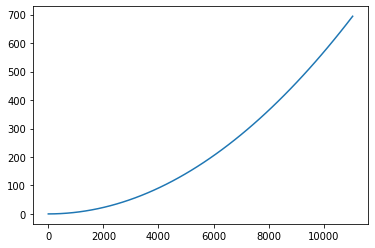

In [97]:
plt.plot(x0, z0)
plt.show()

In [98]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [99]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0

In [100]:
def static_func(Q): # here
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])
#     Z0=np.dot(Re_b(Ret),tau_force[:3])
    Z1 = d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None), tau_force[:3],flag=1).T
#     test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)

#     Z1 = d_s(ne, x, y, z, Ret, test).T
    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 #+ Z0
    
    
############################################################ 
    ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################    

#     C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
#                         Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    C3=d_me(φ,θ,ψ,Ret,  ωe,ωe(φ,θ,ψ,None,None,None),tau_force[3:])
    B_ =C3
    B=(B_ #+ C0.squeeze()
      )

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans  

In [101]:
q0

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [102]:
root = fsolve(static_func, q0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [103]:
root

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [104]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [105]:
x0

[0.0,
 225.56499682574736,
 451.1299936514947,
 676.6949904772421,
 902.2599873029894,
 1127.8249841287368,
 1353.3899809544841,
 1578.9549777802315,
 1804.5199746059789,
 2030.0849714317262,
 2255.6499682574736,
 2481.2149650832207,
 2706.7799619089683,
 2932.344958734716,
 3157.909955560463,
 3383.47495238621,
 3609.0399492119577,
 3834.6049460377053,
 4060.1699428634524,
 4285.7349396892,
 4511.299936514947,
 4736.864933340695,
 4962.429930166441,
 5187.994926992189,
 5413.559923817937,
 5639.124920643684,
 5864.689917469432,
 6090.254914295178,
 6315.819911120926,
 6541.384907946674,
 6766.94990477242,
 6992.514901598168,
 7218.079898423915,
 7443.644895249663,
 7669.209892075411,
 7894.774888901157,
 8120.339885726905,
 8345.904882552652,
 8571.4698793784,
 8797.034876204147,
 9022.599873029894,
 9248.164869855642,
 9473.72986668139,
 9699.294863507137,
 9924.859860332883,
 10150.42485715863,
 10375.989853984378,
 10601.554850810126,
 10827.119847635873,
 11052.68484446162]

In [106]:
x0_

array([    0.        ,   225.56499683,   451.12999365,   676.69499048,
         902.2599873 ,  1127.82498413,  1353.38998095,  1578.95497778,
        1804.51997461,  2030.08497143,  2255.64996826,  2481.21496508,
        2706.77996191,  2932.34495873,  3157.90995556,  3383.47495239,
        3609.03994921,  3834.60494604,  4060.16994286,  4285.73493969,
        4511.29993651,  4736.86493334,  4962.42993017,  5187.99492699,
        5413.55992382,  5639.12492064,  5864.68991747,  6090.2549143 ,
        6315.81991112,  6541.38490795,  6766.94990477,  6992.5149016 ,
        7218.07989842,  7443.64489525,  7669.20989208,  7894.7748889 ,
        8120.33988573,  8345.90488255,  8571.46987938,  8797.0348762 ,
        9022.59987303,  9248.16486986,  9473.72986668,  9699.29486351,
        9924.85986033, 10150.42485716, 10375.98985398, 10601.55485081,
       10827.11984764, 11052.68484446])

In [107]:
z0

[0.0,
 0.2888428427924309,
 1.155373265710624,
 2.5995969523577234,
 4.621523375418674,
 7.221165796797117,
 10.398541267595833,
 14.15367062831231,
 18.486578508975636,
 23.39729332924428,
 28.885847298621222,
 34.95227641670818,
 41.59662047340119,
 48.81892304912524,
 56.619231515186364,
 64.99759703402582,
 73.9540745596112,
 83.48872283771031,
 93.60160440638002,
 104.29278559627915,
 115.56233653119654,
 127.41033112846175,
 139.83684709937523,
 152.8419659498538,
 166.4257729808412,
 180.58835728891447,
 195.3298117668901,
 210.65023310439128,
 226.54972178849314,
 243.02838210444648,
 260.0863221362252,
 277.72365376736735,
 295.94049268164,
 314.7369583638412,
 334.1131741005232,
 354.0692669808534,
 374.60536789741576,
 395.72161154711085,
 417.41813643197673,
 439.6950848601867,
 462.5526029468705,
 485.9908406151509,
 510.0099515971214,
 534.6100934348437,
 559.7914274813454,
 585.5541189017534,
 611.8983366742727,
 638.8242535914375,
 666.3320462610891,
 694.4218951076863]

In [108]:
z0_

array([0.00000000e+00, 2.88842843e-01, 1.15537327e+00, 2.59959695e+00,
       4.62152338e+00, 7.22116580e+00, 1.03985413e+01, 1.41536706e+01,
       1.84865785e+01, 2.33972933e+01, 2.88858473e+01, 3.49522764e+01,
       4.15966205e+01, 4.88189230e+01, 5.66192315e+01, 6.49975970e+01,
       7.39540746e+01, 8.34887228e+01, 9.36016044e+01, 1.04292786e+02,
       1.15562337e+02, 1.27410331e+02, 1.39836847e+02, 1.52841966e+02,
       1.66425773e+02, 1.80588357e+02, 1.95329812e+02, 2.10650233e+02,
       2.26549722e+02, 2.43028382e+02, 2.60086322e+02, 2.77723654e+02,
       2.95940493e+02, 3.14736958e+02, 3.34113174e+02, 3.54069267e+02,
       3.74605368e+02, 3.95721612e+02, 4.17418136e+02, 4.39695085e+02,
       4.62552603e+02, 4.85990841e+02, 5.10009952e+02, 5.34610093e+02,
       5.59791427e+02, 5.85554119e+02, 6.11898337e+02, 6.38824254e+02,
       6.66332046e+02, 6.94421895e+02])

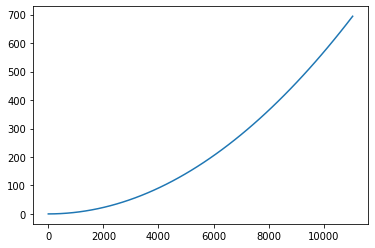

In [109]:
plt.plot(x0_, z0_)
plt.show()

In [110]:
init=1e-6
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0_
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0_
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=init*rng.standard_normal(node_N)
#         q0[(j-1)*node_N]=0
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=init*rng.standard_normal(node_N)
#         q0[(j-1)*node_N]=0
    elif j==9:    
        q0[(j-1)*node_N:j*node_N]=init*np.array([-0.13*i*init for i in range(node_N)])
#         q0[(j-1)*node_N]=0
    elif j==11:   
        q0[(j-1)*node_N:j*node_N]=init*np.array([-0.13*1e-3*i*init for i in range(node_N)])
#         q0[(j-1)*node_N]=0 
# q0[9*node_N-1]=0.13  # here

In [111]:
q0

array([ 0.00000000e+00,  2.25564997e+02,  4.51129994e+02,  6.76694990e+02,
        9.02259987e+02,  1.12782498e+03,  1.35338998e+03,  1.57895498e+03,
        1.80451997e+03,  2.03008497e+03,  2.25564997e+03,  2.48121497e+03,
        2.70677996e+03,  2.93234496e+03,  3.15790996e+03,  3.38347495e+03,
        3.60903995e+03,  3.83460495e+03,  4.06016994e+03,  4.28573494e+03,
        4.51129994e+03,  4.73686493e+03,  4.96242993e+03,  5.18799493e+03,
        5.41355992e+03,  5.63912492e+03,  5.86468992e+03,  6.09025491e+03,
        6.31581991e+03,  6.54138491e+03,  6.76694990e+03,  6.99251490e+03,
        7.21807990e+03,  7.44364490e+03,  7.66920989e+03,  7.89477489e+03,
        8.12033989e+03,  8.34590488e+03,  8.57146988e+03,  8.79703488e+03,
        9.02259987e+03,  9.24816487e+03,  9.47372987e+03,  9.69929486e+03,
        9.92485986e+03,  1.01504249e+04,  1.03759899e+04,  1.06015549e+04,
        1.08271198e+04,  1.10526848e+04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

### Vessle Simulation

In [112]:
sampleTime = 0.01              # sample time [seconds]
N = 5000                      # number of samples

In [113]:
vehicle=semisub('DPcontrol',10,0,40.0,0,0) 

In [114]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [115]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

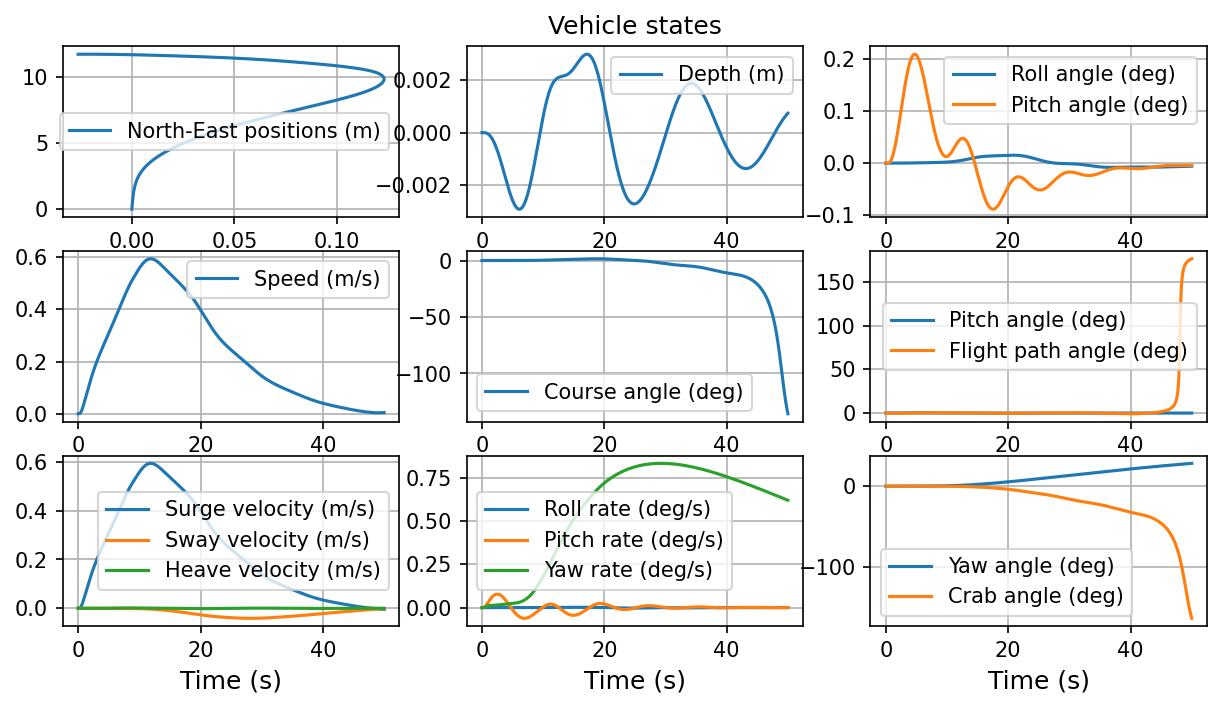

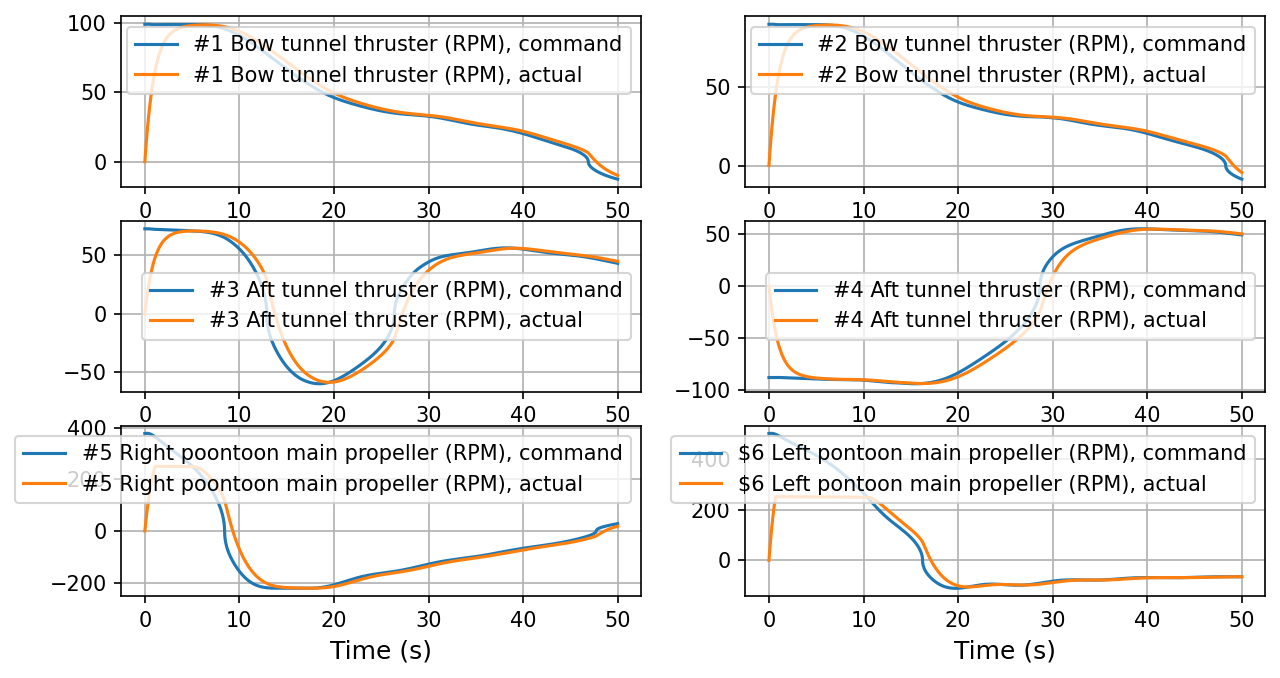

In [116]:
plotVehicleStates(simTime, simData, 1)                    
plotControls(simTime, simData, vehicle, 2)

In [117]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'       

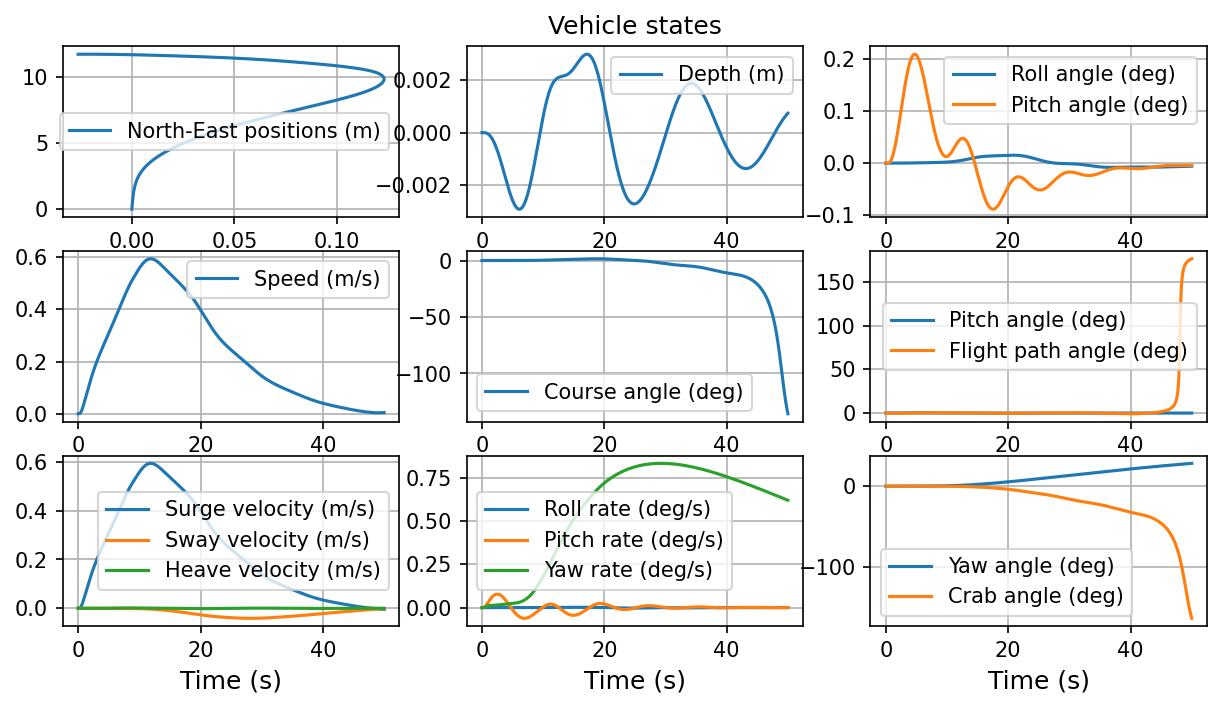

In [118]:
plotVehicleStates(simTime, simData, 3)

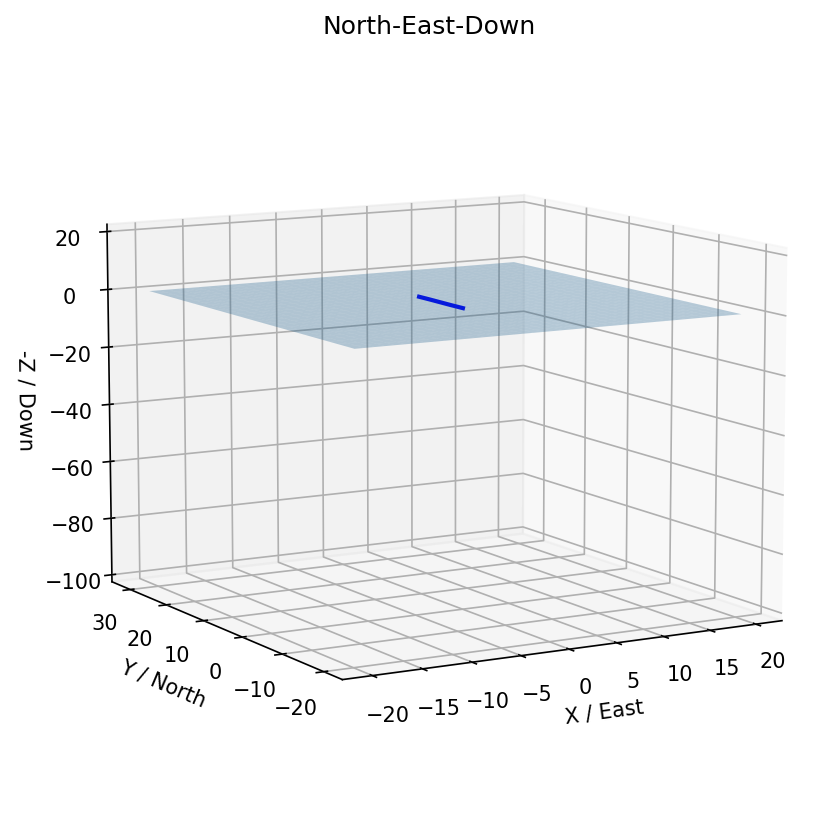

In [119]:
plot3D(simData, numDataPoints, FPS, filename, 3)  

In [120]:
def myDPcontrol(self, eta, nu, sampleTime):
        """
        u = DPcontrol(eta,nu,sampleTime) is a nonlinear PID controller
        for DP based on pole placement:

        tau = -R' Kp (eta-r) - R' Kd R nu - R' Ki int(eta-r)
        u = B_pseudoinverse * tau
        """
        # 3-DOF state vectors
        eta3 = np.array([eta[0], eta[1], eta[5]])
        nu3 = np.array([nu[0], nu[1], nu[5]])

        # 3-DOF diagonal model matrices
        M3 = np.diag([self.M[0][0], self.M[1][1], self.M[5][5]])
        D3 = np.diag([self.D[0][0], self.D[1][1], self.D[5][5]])

        [tau3, self.e_int, self.x_d, self.y_d, self.psi_d] = DPpolePlacement(
            self.e_int,
            M3,
            D3,
            eta3,
            nu3,
            self.x_d,
            self.y_d,
            self.psi_d,
            self.wn,
            self.zeta,
            self.ref,
            sampleTime,
        )
        
        tau=list(tau3)+[tau3[2]*ly - tau3[1]*lz,
                  tau3[0]*lz - tau3[2]*lx,
                  tau3[1]*lx - tau3[0]*ly]

#         u_alloc = self.controlAllocation(tau3)
        return tau

In [121]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [122]:
ssa(simData[:, 4][0+10])

2.9824938962974556e-08

### Dynamics

In [123]:
def grayscott1d(t, Q): # here
#     print(t)
      
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    
    idx = find_nearest(np.array(ans_t),  t) 

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])
    
    
    u_ve = simData[:, 6][idx]
    v_ve = simData[:, 7][idx]
    w_ve = simData[:, 8][idx]
    p_ve = simData[:, 9][idx]
    q_ve = simData[:, 10][idx]
    r_ve = simData[:, 11][idx]
    
    
    η=np.array([x_ve, y_ve, z_ve, phi_ve, theta_ve, psi_v])
    
    dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
    
#     n_ = vehicle.DPcontrol(η,dη,sampleTime) # /1e3
    n_ = myDPcontrol(vehicle,η,dη,sampleTime)
#     print(n_)
    

    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    

    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
#     φ[-1],θ[-1],ψ[-1]=phi_ve, theta_ve,psi_v
    Ret = Re_t(φ,θ,ψ)
#     print(Ret)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
#     force_schedule =1/(1+np.exp(-np.exp(t/10)+np.exp(2)))
#     force_schedule = t/15 if t<15 else 1
#     force_schedule = 1e-1000
    force_schedule=1
#     print(type(n_))
    tau_force = force_schedule*np.array(n_) # [N]
#     tau_force[1]=0
#     tau_force[2]=0
#     tau_force[3]=0
#     tau_force[4]=0
#     tau_force[5]=0

    
#     Z0=np.dot(Re_b(Ret.astype(np.float32)),tau_force[:3].astype(np.float32)).astype(np.float32)
#     print(Z0)
    Z1 =d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None), tau_force[:3],flag=1).T
#     Z1 =d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T
#     print(Z1)
    Z2=ne_(dx,dy,dz,DT,Ret).T

    Z= (Z1 + Z2 #+Z0
       )
#     Z[-1]+=tau_force[:3]

############################################################    

    RRRR=Re_b(Ret)
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',
                                             [Ws[i] for i in range(node_N)]
#                                              +[Ws[-1] + vessel_mass]
                                             ,RRRR),
                                   Z
                                  ).T 
#     print(ddx)
#     print(np.concatenate([ddx, ddy,ddz, dφ,], axis=0))
#     ddx,ddy, ddz = Ret
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T
#     print(ddx)
#     print()
############################################################      

    
 
    
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret).astype(np.float32),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float32), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float32).T))
   

    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float32),np.array([dφ,dθ,dψ]).astype(np.float32).T)

    C2= np.cross(
         test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret).astype(np.float32),
                            test))


    C3=d_me(φ,θ,ψ,Ret, ωe, ωe(φ,θ,ψ,None,None,None),tau_force[3:])
    
#     C4= np.cross(d_s(phi,x,y,z,Ret, phi(x,y,z,Ret,None)).T, ne(x,y,z,Ret, phi(x,y,z,Ret,None)))
    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),[None,None,None]).T, 
                 ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),tau_force[:3]))
#     print(tau_force[:3])
#     C4= np.cross(d_s(phi,x,y,z,Ret, test).T, ne(x,y,z,Ret, test))
    
    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float32).T)

#     C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float32)),
#                         Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ #+C0.squeeze()
#     print(B)   

    A2 = Irho_e(Ret).astype(np.float32)
    A3=Π(φ,θ,ψ).astype(np.float32)

    A=np.einsum('ijk,ikr->ijr',A2,A3)
    
#     hack=1e20
    hack=1e15
############################################
    ddφ,ddθ,ddψ = np.linalg.solve(hack*A,B).T
#############################################


#     ddx[0],ddy[0],ddz[0],ddφ[0],ddθ[0],ddψ[0]=0,0,0,0,0,0
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
#     print(A1111)
    return A1111

In [124]:
tspan = (0., 0.4)

In [125]:
startTime1 = datetime.now()

us=solve_ivp(grayscott1d,  tspan, q0, 
#              nfev=842
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1e9, atol=1e9
            )
print(datetime.now() - startTime1)

0:00:06.011577


In [126]:
# key takeaway: you can calibrate the model by tuning the hack and bc(init) 

### Results

In [127]:
fin=us

In [128]:
fin

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 338
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.        , 0.01028643, 0.1131507 , 0.15937241, 0.20559412,
       0.23091296, 0.2562318 , 0.27473609, 0.29170539, 0.30904929,
       0.32266421, 0.33365203, 0.34163702, 0.34792524, 0.3531024 ,
       0.35742234, 0.36055318, 0.36368401, 0.36589243, 0.36810085,
       0.37057252, 0.37262396, 0.3746754 , 0.37682172, 0.37847966,
       0.38013761, 0.38238534, 0.38447051, 0.38655567, 0.38859819,
       0.39049773, 0.39259575, 0.39370724, 0.39481873, 0.39588715,
       0.39695556, 0.39811798, 0.39933062, 0.4       ])
 t_events: None
        y: array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 2.25564997e+02,  2.25564997e+02,  2.25564997e+02, ...,
         2.25553822e+02,  2.25553527e+02,  2.25553478e+02],
       [ 4.51129994e+

In [129]:
t=fin.t

In [130]:
fin=fin.y.T

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


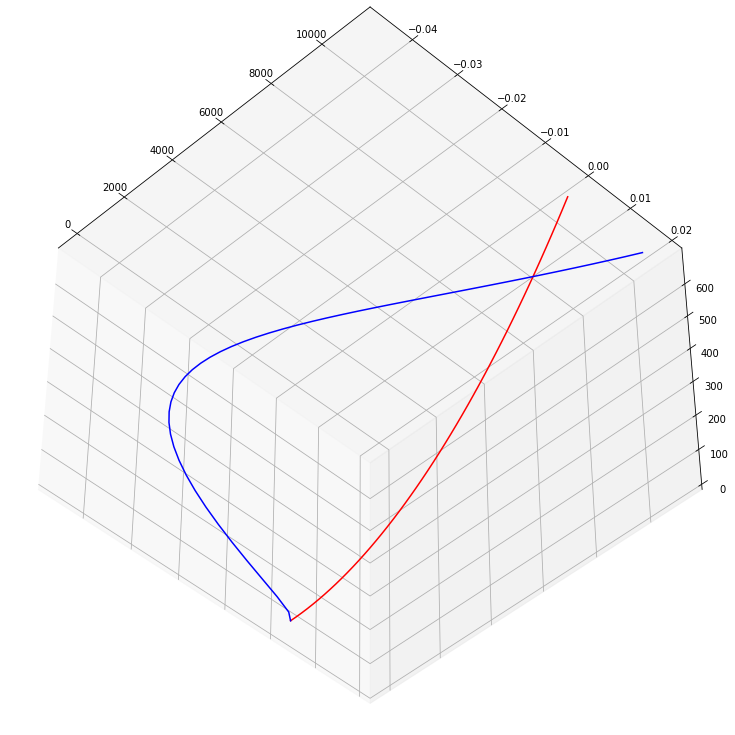

In [131]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)


ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
# ax.plot(x_fine, y_fine, z_fine, color='b')
ax.view_init(-45,-45)
# ax.view_init(0,-90)
plt.show()

In [132]:
X,Y,Z

(array([    0.        ,   225.55347809,   451.0881158 ,   676.61247613,
          902.1337514 ,  1127.65604502,  1353.18113673,  1578.70951538,
         1804.24103555,  2029.7753093 ,  2255.31187552,  2480.85030267,
         2706.39018661,  2931.93122832,  3157.47314574,  3383.0157143 ,
         3608.55880863,  3834.10232918,  4059.6461395 ,  4285.19015337,
         4510.73433346,  4736.2786418 ,  4961.82302077,  5187.36748333,
         5412.9120247 ,  5638.45658052,  5864.00114283,  6089.54570968,
         6315.09027844,  6540.63484839,  6766.17941972,  6991.72399265,
         7217.26856768,  7442.81314731,  7668.35773213,  7893.90232264,
         8119.44689625,  8344.99145183,  8570.53598708,  8796.08050718,
         9021.62501611,  9247.16951647,  9472.71400597,  9698.25848648,
         9923.80295865, 10149.34741949, 10374.89186789, 10600.43629281,
        10825.98067591, 11051.52495985]),
 array([ 0.        , -0.00164839, -0.00543687, -0.00992685, -0.01448365,
        -0.01889149, 

In [133]:
X0,Y0,Z0

(array([    0.        ,   225.56499683,   451.12999365,   676.69499048,
          902.2599873 ,  1127.82498413,  1353.38998095,  1578.95497778,
         1804.51997461,  2030.08497143,  2255.64996826,  2481.21496508,
         2706.77996191,  2932.34495873,  3157.90995556,  3383.47495239,
         3609.03994921,  3834.60494604,  4060.16994286,  4285.73493969,
         4511.29993651,  4736.86493334,  4962.42993017,  5187.99492699,
         5413.55992382,  5639.12492064,  5864.68991747,  6090.2549143 ,
         6315.81991112,  6541.38490795,  6766.94990477,  6992.5149016 ,
         7218.07989842,  7443.64489525,  7669.20989208,  7894.7748889 ,
         8120.33988573,  8345.90488255,  8571.46987938,  8797.0348762 ,
         9022.59987303,  9248.16486986,  9473.72986668,  9699.29486351,
         9924.85986033, 10150.42485716, 10375.98985398, 10601.55485081,
        10827.11984764, 11052.68484446]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.

In [134]:
us=fin.T

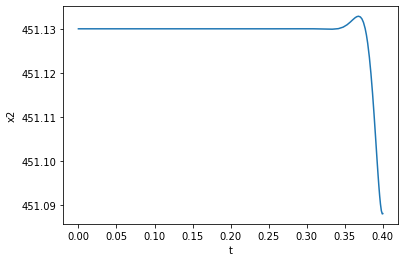

In [135]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

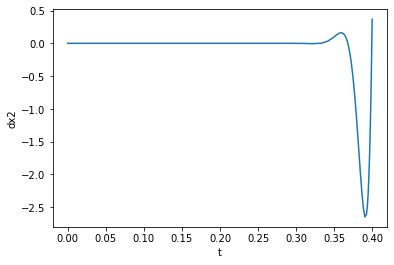

In [136]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

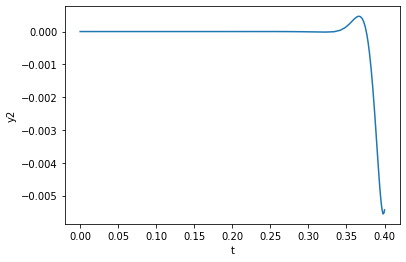

In [137]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

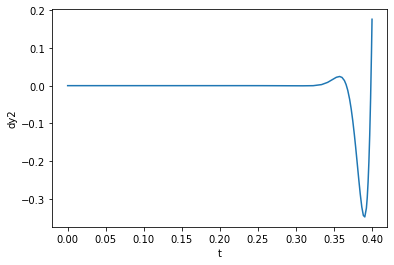

In [138]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

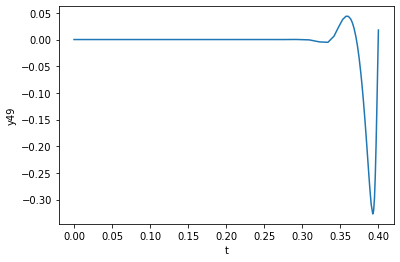

In [139]:
plt.plot(t,us.T[:,2*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('y49')
plt.show()

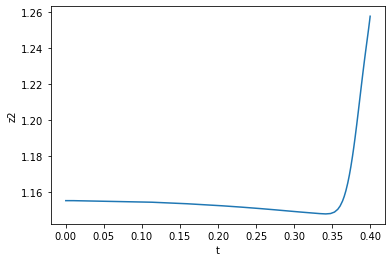

In [140]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

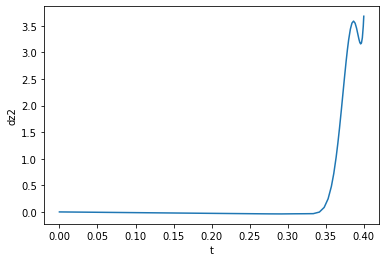

In [141]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

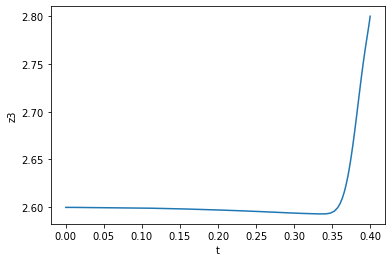

In [142]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

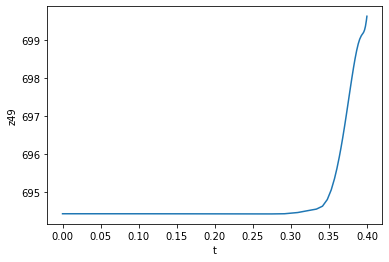

In [143]:
plt.plot(t,us.T[:,4*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('z49')
plt.show()

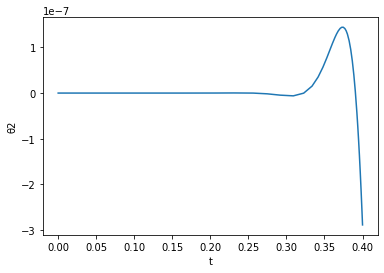

In [144]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

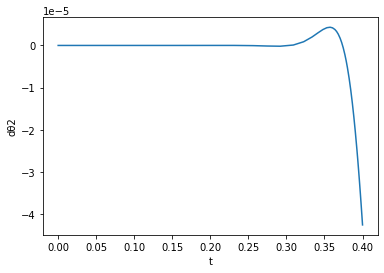

In [145]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

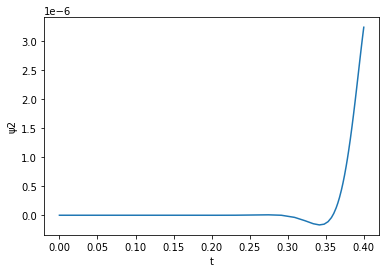

In [146]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

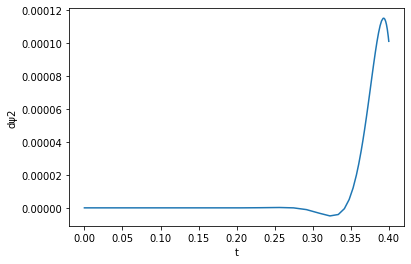

In [147]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()